In [ ]:
!pip install gensim==4.2.0

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Embedding, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.regularizers import l2, l1
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
import pandas as pd
import random
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K
from keras.models import Model
from nltk import tokenize
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.callbacks import Callback, ModelCheckpoint


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load Data and Basic Text cleaning

In [3]:
news_articles = shuffle(pd.read_json("/content/drive/My Drive/python/News_Category_Dataset_v2.json", lines = True)).reset_index()
news_articles['text'] = news_articles['headline'] +'. ' +news_articles['short_description']
news_articles.category = news_articles.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
news_articles = news_articles[['text', 'category']]
text_chunks = news_articles['text'].tolist()
remove_chars = '[·’!"\#$%&\'()#!()*+,-./:;<=>?\@,:?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'
for i in range(len(text_chunks)):
    sentence = text_chunks[i]
    cleaned = re.sub(remove_chars, "", sentence)
    cleaned = cleaned.strip()
    cleaned = cleaned.lower()
    text_chunks[i] = cleaned

news_articles['cleaned_headline'] = text_chunks
#remove rows with empty headlines
news_articles = news_articles[news_articles['cleaned_headline'] != '']
#remove headlines with less than 20 words
#news_articles = news_articles[news_articles['cleaned_headline'].str.split().str.len() > 10]
#remove duplicate headlines
news_articles = news_articles.drop_duplicates(subset=['cleaned_headline'])

from sklearn.utils import class_weight

#w = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
w = class_weight.compute_class_weight(class_weight ='balanced', classes = news_articles['category'].unique(), y = news_articles['category'])

# here I am adding only two categories with their corresponding weights
# you can spin a loop or continue by hand until you include all of your categories
class_weights = dict(enumerate(w))

# Samppling from the dataset

In [ ]:
df2 = news_articles[news_articles['category'].isin(['POLITICS','WELLNESS','ENTERTAINMENT','TRAVEL','STYLE & BEAUTY','PARENTING','QUEER VOICES','FOOD & DRINK','BUSINESS','HEALTHY LIVING'])]
label = set(df2['category'])
label_dict = {}
label_dict2 = {}
for idx, text in enumerate(label):
  label_dict[text] = idx
  label_dict2[idx] = text
df2['category'] = [label_dict[label] for label in df2['category']]
df2.head()

# Vectorizing Method

In [5]:
sentences = df2['cleaned_headline'].values
y = df2['category']
#new_df = pd.DataFrame({'text':aug_text,'label':aug_label})
#sentences = new_df['text'].values
#y = new_df['label']
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
#print (X_train.shape)
#print (X_train[0].toarray())

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

#from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

y_train = y_train.astype('category')
y_train = y_train.cat.codes
X_train, y_train = X_train, tf.one_hot(y_train, 10)

y_test = y_test.astype('category')
y_test = y_test.cat.codes
X_test, y_test = X_test, tf.one_hot(y_test, 10)

#过滤无关词语
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # keras文档中指定需要+1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/My Drive/python/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)


In [6]:
import pickle

with open('/content/drive/My Drive/python/partial_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# First LSTM model

In [7]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           #maxlen
                           trainable=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64)) 
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, kernel_regularizer=l2(0.05), activation='softmax'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=8,
                    validation_data=(X_test, y_test),
                    batch_size=128,
                    class_weight = class_weights)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

Epoch 1/8


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


702/702 [==============================] - 20s 16ms/step - loss: 1.1260 - accuracy: 0.4820 - val_loss: 1.2300 - val_accuracy: 0.6443
Epoch 2/8
702/702 [==============================] - 10s 14ms/step - loss: 0.7088 - accuracy: 0.7051 - val_loss: 1.0143 - val_accuracy: 0.7275
Epoch 3/8
702/702 [==============================] - 11s 16ms/step - loss: 0.6109 - accuracy: 0.7396 - val_loss: 1.0092 - val_accuracy: 0.7251
Epoch 4/8
702/702 [==============================] - 10s 14ms/step - loss: 0.5473 - accuracy: 0.7605 - val_loss: 1.0061 - val_accuracy: 0.7352
Epoch 5/8
702/702 [==============================] - 12s 17ms/step - loss: 0.4963 - accuracy: 0.7779 - val_loss: 1.0198 - val_accuracy: 0.7335
Epoch 6/8
702/702 [==============================] - 10s 14ms/step - loss: 0.4514 - accuracy: 0.7928 - val_loss: 0.9747 - val_accuracy: 0.7283
Epoch 7/8
702/702 [==============================] - 11s 16ms/step - loss: 0.4052 - accuracy: 0.8098 - val_loss: 0.9519 - val_accuracy: 0.7441
Epoch 8/8

In [8]:
model.save('/content/drive/My Drive/python/model/Partial_LSTM_All_model')

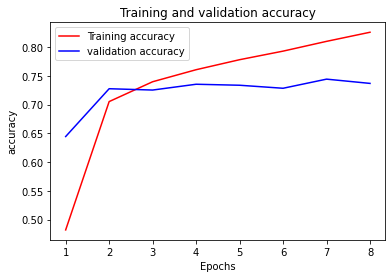

In [10]:
import matplotlib.pyplot as plt
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy'])+1) 
plt.plot(epochs,accuracy_values,color='red',label='Training accuracy') 
plt.plot(epochs,val_accuracy_values, color = 'blue',label = 'validation accuracy') 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# First CNN model

In [11]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, kernel_regularizer=l2(0.005), activation='relu'))
model.add(layers.Dense(10, kernel_regularizer=l2(0.005), activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=7,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=128,
                    class_weight = class_weights)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history,name='CNN')

Epoch 1/7
702/702 [==============================] - 9s 7ms/step - loss: 1.2824 - accuracy: 0.4478 - val_loss: 1.4236 - val_accuracy: 0.5730
Epoch 2/7
702/702 [==============================] - 4s 6ms/step - loss: 0.8580 - accuracy: 0.6018 - val_loss: 1.2823 - val_accuracy: 0.6197
Epoch 3/7
702/702 [==============================] - 5s 6ms/step - loss: 0.7460 - accuracy: 0.6586 - val_loss: 1.2047 - val_accuracy: 0.6506
Epoch 4/7
702/702 [==============================] - 5s 6ms/step - loss: 0.6641 - accuracy: 0.6979 - val_loss: 1.1377 - val_accuracy: 0.6746
Epoch 5/7
702/702 [==============================] - 4s 6ms/step - loss: 0.6046 - accuracy: 0.7263 - val_loss: 1.0912 - val_accuracy: 0.6968
Epoch 6/7
702/702 [==============================] - 4s 6ms/step - loss: 0.5580 - accuracy: 0.7445 - val_loss: 1.0969 - val_accuracy: 0.7005
Epoch 7/7
702/702 [==============================] - 5s 8ms/step - loss: 0.5170 - accuracy: 0.7606 - val_loss: 1.0771 - val_accuracy: 0.7015
Training Accu

In [12]:
model.save('/content/drive/My Drive/python/model/partial_1D-CNN_All_model')

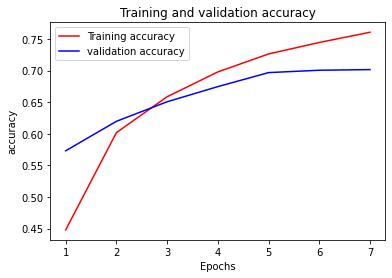

In [14]:
import matplotlib.pyplot as plt
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy'])+1) 
plt.plot(epochs,accuracy_values,color='red',label='Training accuracy') 
plt.plot(epochs,val_accuracy_values, color = 'blue',label = 'validation accuracy') 
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# HAN Model

In [ ]:
!pip install tensorflow==2.4.2

In [16]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [17]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config


In [31]:
max_features=200000
max_senten_len=10
max_senten_num=6
embed_size=100

paras = []
labels = []
texts = []

In [32]:
df2.text.shape[0]

119786

In [33]:
sent_lens = []
sent_nums = []
df3 = df2.reset_index(drop=True)
for idx in range(df3.text.shape[0]):
    text = df3.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)


In [34]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [35]:
import pickle

with open('/content/drive/My Drive/python/partial_HAN_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent) # get words in a sentence
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

— david
gratisography
and it's
bob mcdonnell


In [39]:
labels = pd.get_dummies(df3['category'])

In [40]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (119786, 6, 10)
Shape of labels tensor: (119786, 10)


In [41]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [42]:
GLOVE_DIR = "/content/drive/My Drive/python/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))


Total 400000 word vectors.


In [43]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1

In [44]:
word_index = tokenizer.word_index
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [45]:
l2_reg = l2(0.0001)
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(10, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [46]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [48]:
#checkpoint = ModelCheckpoint(filepath='model_path.h5', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=512, callbacks=[checkpoint])

Epoch 1/10
188/188 [==============================] - 12s 62ms/step - loss: 0.9094 - acc: 0.7463 - val_loss: 0.8674 - val_acc: 0.7514
Epoch 2/10
188/188 [==============================] - 10s 51ms/step - loss: 0.8327 - acc: 0.7652 - val_loss: 0.8106 - val_acc: 0.7678
Epoch 3/10
188/188 [==============================] - 10s 51ms/step - loss: 0.7829 - acc: 0.7793 - val_loss: 0.7933 - val_acc: 0.7712
Epoch 4/10
188/188 [==============================] - 10s 51ms/step - loss: 0.7462 - acc: 0.7900 - val_loss: 0.7717 - val_acc: 0.7765
Epoch 5/10
188/188 [==============================] - 9s 51ms/step - loss: 0.7150 - acc: 0.7997 - val_loss: 0.7606 - val_acc: 0.7812
Epoch 6/10
188/188 [==============================] - 9s 49ms/step - loss: 0.6900 - acc: 0.8064 - val_loss: 0.7645 - val_acc: 0.7819
Epoch 7/10
188/188 [==============================] - 9s 49ms/step - loss: 0.6660 - acc: 0.8126 - val_loss: 0.7719 - val_acc: 0.7768
Epoch 8/10
188/188 [==============================] - 9s 50ms/ste

In [49]:
model.save('/content/drive/My Drive/python/model/partial_HAN_All_model')

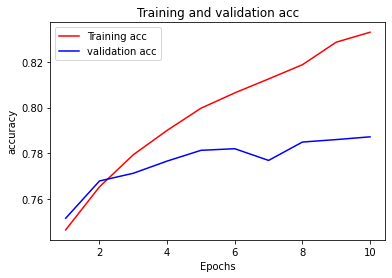

In [50]:
import matplotlib.pyplot as plt
history_dict = history.history
accuracy_values = history_dict['acc']
val_accuracy_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc'])+1) 
plt.plot(epochs,accuracy_values,color='red',label='Training acc') 
plt.plot(epochs,val_accuracy_values, color = 'blue',label = 'validation acc') 
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Testing Demo

In [51]:
a_file = open("/content/drive/My Drive/python/partial_label_dict.pkl", "wb")
pickle.dump(label_dict2, a_file)
a_file.close()


In [52]:
from keras.utils import pad_sequences
import keras
import numpy as np

a_file = open("/content/drive/My Drive/python/partial_label_dict.pkl", "rb")
label_dict2 = pickle.load(a_file)
a_file.close()

def generator(text):  
  max_features=200000
  max_senten_len=10
  max_senten_num=6
  embed_size=100

  paras = []
  labels = []
  texts = []

  df = pd.DataFrame({'text':[text]})
  sent_lens = []
  sent_nums = []
  text = df['text'][0]
  texts.append(text)
  sentences = tokenize.sent_tokenize(text)
  sent_nums.append(len(sentences))
  for sent in sentences:
      sent_lens.append(len(text_to_word_sequence(sent)))
  paras.append(sentences)

  data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
  for i, sentences in enumerate(paras):
      for j, sent in enumerate(sentences):
          if j< max_senten_num:
              wordTokens = text_to_word_sequence(sent) # get words in a sentence
              k=0
              for _, word in enumerate(wordTokens):
                  try:
                      if k<max_senten_len and tokenizer.word_index[word]<max_features:
                          data[i,j,k] = tokenizer.word_index[word]
                          k=k+1
                  except:
                      pass
  indices = np.arange(data.shape[0])
  np.random.shuffle(indices)
  data = data[indices]
  x_train = data
  return x_train

def classify():
  test_text = input('Input your string:')
  model = input('choose your model (LSTM/CNN/HAN):')
  if model == 'LSTM':
    model = keras.models.load_model('/content/drive/My Drive/python/partial_model/LSTM_All_model')
    with open('/content/drive/My Drive/python/partial_tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
    test_text = np.array([test_text],dtype=object)
    test_text = tokenizer.texts_to_sequences(test_text)
    test_text = pad_sequences(test_text, padding='post', maxlen=30)
    prediction = model.predict(test_text)
    label = label_dict2[np.argmax(prediction)]
  elif model == 'CNN':
    model = keras.models.load_model('/content/drive/My Drive/python/model/partial_1D-CNN_All_model')
    with open('/content/drive/My Drive/python/partial_tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
    test_text = np.array([test_text],dtype=object)
    test_text = tokenizer.texts_to_sequences(test_text)
    test_text = pad_sequences(test_text, padding='post', maxlen=30)
    prediction = model.predict(test_text)
    label = label_dict2[np.argmax(prediction)]
  else:
    model = keras.models.load_model('/content/drive/My Drive/python/model/partial_HAN_All_model')
    with open('/content/drive/My Drive/python/partial_HAN_tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
    test_text = generator(test_text)
    prediction = model.predict(test_text)
    label = label_dict2[np.argmax(prediction)]
  return label


In [53]:
classify()

Input your string:I have a house and eat well
choose your model (LSTM/CNN/HAN):HAN
1/1 [==============================] - 1s 1s/step


'HEALTHY LIVING'